In [1]:
#!pip install --upgrade pip imbalanced-learn
#!pip install tensorflow-gpu==1.14

In [2]:
import pickle
import math
from math import sqrt
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import Counter
import tensorflow.keras as K
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize as scikit_normalize
from sklearn.utils import shuffle as  sklearn_shuffle

from IPython.core.display import display
from IPython.core.display import HTML

%matplotlib inline

In [3]:
DATASET='/home/kvassay/data/z/data/reviews_train_test_dev1_{}.pickle'
TYPE='tok'

## Load data

In [4]:
%%time
with open(DATASET.format(TYPE),'rb') as f:
    train,dev,test=pickle.load(f)

CPU times: user 4.54 s, sys: 1.19 s, total: 5.73 s
Wall time: 5.68 s


## Train TF vectorizer model

In [5]:
def tf_train(dataset,key, **scikit_kwargs):
    vectorizer=TfidfVectorizer(**scikit_kwargs)
    vectorizer.fit([' '.join(x[key]) for x in dataset])
    return vectorizer

def tf_predict(vectorizer,dataset,key, apply_norm=True):
    features=vectorizer.transform([' '.join(x[key]) for x in dataset])
    if apply_norm is True:
        features=scikit_normalize(features)
    return features

def extract_features(dataset,vectorizer_summary,vectorizer_text):
    summ_vecs=tf_predict(vectorizer_summary,dataset,'summary')
    text_vecs=tf_predict(vectorizer_text,dataset,'text')
    return hstack([summ_vecs, text_vecs],format='csr')

In [6]:
%%time
vectorizer_text=tf_train(train,'text',max_features=35000,ngram_range=(1,2),max_df=0.99,lowercase=True,use_idf=False)
vectorizer_summary=tf_train(train,'summary',max_features=5000,ngram_range=(1,2),max_df=0.99,lowercase=True,use_idf=False)

CPU times: user 1min 13s, sys: 1.79 s, total: 1min 15s
Wall time: 1min 14s


## Extract features

In [7]:
%%time
X_train=extract_features(train, vectorizer_summary,vectorizer_text)
X_dev=extract_features(dev, vectorizer_summary,vectorizer_text)
y_train=np.array([x['score'] for x in train])
y_dev=np.array([x['score'] for x in dev])
print('Train samples shape: {}, Dev samples shape: {}'.format(X_train.shape,X_dev.shape))

Train samples shape: (551399, 40000), Dev samples shape: (8527, 40000)
CPU times: user 58 s, sys: 1.5 s, total: 59.5 s
Wall time: 59.5 s


## Training

In [8]:
class UnderSampler(K.utils.Sequence):

    def __init__(self, X, y, batch_size):
        self.rus=RandomUnderSampler(sampling_strategy='not minority')
        self.X, self.y = X, y
        self.batch_size = batch_size
        #len
        self._shuffle()
        self.length= math.ceil(self.X_u.shape[0] / self.batch_size)

    def _shuffle(self):
        self.X_u, self.y_u=self.rus.fit_resample(self.X,self.y)
        self.X_u,self.y_u = sklearn_shuffle(self.X_u,self.y_u)
        
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        batch_x = self.X_u[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y_u[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x.todense(), batch_y
    
    def on_epoch_end(self):
        self._shuffle()
        
class RandomSampler(K.utils.Sequence):

    def __init__(self, X, y, batch_size):
        self.X, self.y = X, y
        self.batch_size = batch_size
        self.sampling_size=np.min([x for (_,x) in dict(Counter(y)).items()])*len(set(y))
        #len
        self._shuffle()
        self.length= math.ceil(self.X_u.shape[0] / self.batch_size)

    def _shuffle(self):
        self.X_u,_,self.y_u,_=train_test_split(self.X,self.y,shuffle=True,train_size=self.sampling_size)
        
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        batch_x = self.X_u[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y_u[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x.todense(),batch_y
    
    def on_epoch_end(self):
        self._shuffle()

In [9]:
def train_model(batch_size=100, epochs=5, sampler_cls=UnderSampler):
    model = K.models.Sequential([
        K.layers.Dense(100,activation='relu', input_shape=(X_train.shape[1],)),
        K.layers.Dense(1,activation='linear')
    ])
    opt=K.optimizers.Adam(lr=0.02, amsgrad=True)
    model.compile(optimizer=opt,loss='mean_squared_error')
    sampler=sampler_cls(X_train,y_train,batch_size=batch_size)
    model.fit_generator(sampler, shuffle=False, epochs=epochs, validation_data=(X_dev.todense(),y_dev))
    return model

## Evaluate

In [10]:
def plot_history(model,title):
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, color='red', label='MSE Train')
    plt.plot(epochs, val_loss, color='green', label='MSE Dev')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()
    
def plot_history_double(history1, history2, name1, name2, title):
    loss1 = history1.history['loss']
    val_loss1 = history1.history['val_loss']
    epochs1 = range(1, len(loss1) + 1)
    loss2 = history2.history['loss']
    val_loss2 = history2.history['val_loss']
    epochs2 = range(1, len(loss1) + 1)
    plt.plot(epochs1, loss1, color='red', label='{}: MSE Train'.format(name1))
    plt.plot(epochs1, val_loss1, color='orange', label='{}: MSE Dev'.format(name1))
    plt.plot(epochs2, loss2, color='blue', label='{}: MSE Train'.format(name2))
    plt.plot(epochs2, val_loss2, color='green', label='{}: MSE Dev'.format(name2))
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()



def rmse(y_true,y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

def rmse_partial_avg(y_true, y_pred):
    rmse_dict=rmse_partial(y_true,y_pred)
    values=list(rmse_dict.values())
    return np.mean(values), np.std(values)

def rmse_partial_max(y_true, y_pred):
    rmse_dict=rmse_partial(y_true,y_pred)
    values=list(rmse_dict.values())
    return np.max(values)

def rmse_partial(y_true, y_pred):
    all_scores=list(set(y_true))
    y_true_dict={x:[] for x in all_scores}
    y_pred_dict={x:[] for x in all_scores}
    for i, score in enumerate(y_true):
        y_true_dict[score].append(score)
        y_pred_dict[score].append(y_pred[i])
    return {score: rmse(y_true_dict[score],y_pred_dict[score]) for score in all_scores}

def rmse_report(y_true,y_pred,round_decimals=3, title='RMSE report'):
    def ar(x):
        return np.around(x,decimals=round_decimals)
    baseline=rmse(y_true,[5.0]*len(y_true))
    HTML_TEMPLATE="""
    <h2> {} </h2>
    <h3> RMSE </h3>
    <hr>
    <div>
        <table>
            <tr>
                <td>RMSE (baseline &forall;1.0)</td>
                <td>{}</td>
            </tr>
            <tr>
                <td>RMSE</td>
                <td>{}</td>
            </tr>
        </table>
    <hr>
    <h3> Partial RMSE </h3>
        <table>
            <tr>
                <td>Mean partial RMSE (baseline &forall;1.0)</td>
                <td>{}</td>
            </tr>
            <tr>
                <td>Max partial RMSE (baseline &forall;1.0)</td>
                <td>{}</td>
            </tr>
            <tr>
                <td>St.dev. partial RMSE (baseline &forall;1.0)</td>
                <td>{}</td>
            </tr>
            <tr>
                <td>Mean partial RMSE</td>
                <td><b>{}</b></td>
            </tr>
            <tr>
                <td>Max partial RMSE</td>
                <td>{}</td>
            </tr>
            <tr>
                <td>St.dev. partial RMSE</td>
                <td>{}</td>
            </tr>            
        </table>
    </div>
    <h3> Improvement over baseline (&forall;1.0) </h3>
    <hr>
    <div>
        <table>
            <tr>
                <td>RMSE</td>
                <td>{}</td>
            </tr>
            <tr>
                <td>Mean partial RMSE</td>
                <td><b>{}</b></td>
            </tr>
            <tr>
                <td>Max partial RMSE</td>
                <td>{}</td>
            </tr>
        </table>
    </div>
    
    <h3> Partial RMSE detailed</h3>
    <hr>
    <div>
        <table>
            <tr>
                <th>Review Score</th>
                <th>RMSE</th>
                <th>RMSE baseline (&forall;1.0)</th>
                <th>Improvement over baseline</th>
            </tr>
            {}
        </table>
    </div>
    """
    PARTIAL_ROW_TEMPLATE='''
    <tr>
        <td>
            {}
        </td>
        <td>
            {}
        </td>
        <td>
            {}
        </td>
        <td>
            {}
        </td>
    </tr>
    '''
    overall=rmse(y_true,y_pred)
    partial_avg,partial_std=rmse_partial_avg(y_true,y_pred)
    partial_max=rmse_partial_max(y_true,y_pred)
    partial_avg_baseline,partial_std_baseline=rmse_partial_avg(y_true,[5.0]*len(y_true))
    partial_max_baseline=rmse_partial_max(y_true,[5.0]*len(y_true))
    improvement_marmse=partial_avg_baseline-partial_avg
    improvement_rmse=baseline-overall
    improvement_rmse_partial_max=partial_max_baseline - partial_max
    
    #partial rows
    partial=rmse_partial(y_true,y_pred)
    partial_baseline=rmse_partial(y_true, [5.0]*len(y_true))
    partial=sorted(partial.items(),key=lambda x:x[0],reverse=True)
    partial_table_rows=[]
    for key,value in partial:
        value_baseline=partial_baseline[key]
        diff_baseline=value_baseline-value
        partial_table_rows.append(PARTIAL_ROW_TEMPLATE.format(key,ar(value),ar(value_baseline),ar(diff_baseline)))
    partial_table_rows='\n'.join(partial_table_rows)
    
    html=HTML_TEMPLATE.format(title,
                              ar(baseline),
                              ar(overall),
                              ar(partial_avg_baseline),
                              ar(partial_max_baseline),
                              ar(partial_std_baseline),
                              ar(partial_avg),
                              ar(partial_max),
                              ar(partial_std),
                              ar(improvement_rmse),
                              ar(improvement_marmse),
                              ar(improvement_rmse_partial_max),
                              partial_table_rows)
    display(HTML(html))

def experiment(sampling_cls,epochs,batch_size,name):
    model=train_model(sampler_cls=sampling_cls,epochs=epochs,batch_size=batch_size)
    y_pred_dev=model.predict(X_dev)
    rmse_report(y_dev,y_pred_dev,title='{} - RMSE report'.format(name))
    plot_history(model,title='{} - Train/Dev MSE'.format(name))
    return model.history

W0824 17:27:08.047923 140592922265408 deprecation.py:506] From /home/kvassay/.virtualenvs/main/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/10
482/482 [==============================] - 47s 97ms/step - loss: 0.8339 - val_loss: 0.6251
Epoch 2/10
482/482 [==============================] - 27s 56ms/step - loss: 0.4935 - val_loss: 0.4876
Epoch 3/10
482/482 [==============================] - 26s 54ms/step - loss: 0.4371 - val_loss: 0.5049
Epoch 4/10
482/482 [==============================] - 25s 52ms/step - loss: 0.3978 - val_loss: 0.4242
Epoch 5/10
482/482 [==============================] - 26s 54ms/step - loss: 0.3740 - val_loss: 0.4123
Epoch 6/10
482/482 [==============================] - 26s 53ms/step - loss: 0.3550 - val_loss: 0.3997
Epoch 7/10
482/482 [==============================] - 26s 54ms/step - loss: 0.3327 - val_loss: 0.4190
Epoch 8/10
482/482 [==============================] - 26s 53ms/step - loss: 0.3095 - val_loss: 0.3842
Epoch 9/10
482/482 [==============================] - 26s 54ms/step - loss: 0.2926 - val_loss: 0.3666
Epoch 10/10
482/482 [==============================] - 26s 54ms/step - loss: 0.276

RMSE (baseline ∀1.0),1.53
RMSE,0.601
Mean partial RMSE (baseline ∀1.0),2.0
Max partial RMSE (baseline ∀1.0),4.0
St.dev. partial RMSE (baseline ∀1.0),1.414
Mean partial RMSE,0.734
Max partial RMSE,0.974
St.dev. partial RMSE,0.171
RMSE,0.929
Mean partial RMSE,1.266
Max partial RMSE,3.026


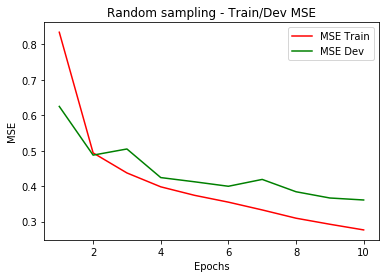

In [11]:
history1=experiment(sampling_cls=RandomSampler,epochs=10,batch_size=300,name='Random sampling')

Epoch 1/10
482/482 [==============================] - 46s 95ms/step - loss: 0.7850 - val_loss: 0.8063
Epoch 2/10
482/482 [==============================] - 46s 95ms/step - loss: 0.5242 - val_loss: 0.6696
Epoch 3/10
482/482 [==============================] - 46s 95ms/step - loss: 0.4672 - val_loss: 0.6110
Epoch 4/10
482/482 [==============================] - 46s 95ms/step - loss: 0.4283 - val_loss: 0.5841
Epoch 5/10
482/482 [==============================] - 46s 95ms/step - loss: 0.3951 - val_loss: 0.5968
Epoch 6/10
482/482 [==============================] - 46s 95ms/step - loss: 0.3670 - val_loss: 0.7184
Epoch 7/10
482/482 [==============================] - 46s 95ms/step - loss: 0.3417 - val_loss: 0.5480
Epoch 8/10
482/482 [==============================] - 46s 95ms/step - loss: 0.3201 - val_loss: 0.5489
Epoch 9/10
482/482 [==============================] - 46s 95ms/step - loss: 0.2972 - val_loss: 0.6568
Epoch 10/10
482/482 [==============================] - 46s 95ms/step - loss: 0.279

RMSE (baseline ∀1.0),1.53
RMSE,0.744
Mean partial RMSE (baseline ∀1.0),2.0
Max partial RMSE (baseline ∀1.0),4.0
St.dev. partial RMSE (baseline ∀1.0),1.414
Mean partial RMSE,0.692
Max partial RMSE,0.776
St.dev. partial RMSE,0.065
RMSE,0.786
Mean partial RMSE,1.308
Max partial RMSE,3.224


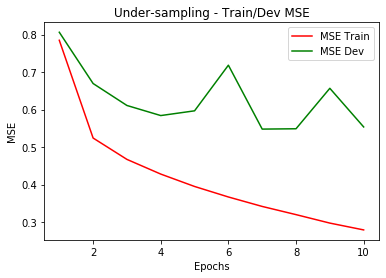

In [12]:
history2=experiment(sampling_cls=UnderSampler,epochs=10,batch_size=300,name='Under-sampling')

## Compare training curves

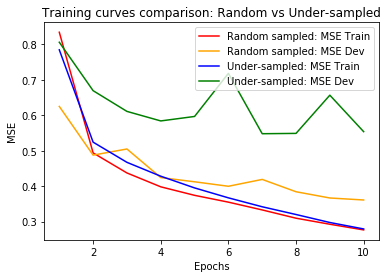

In [13]:
plot_history_double(history1, history2, 'Random sampled','Under-sampled', 'Training curves comparison: Random vs Under-sampled')

## Conclusion: 
- random sampling strategy outperformes in terms of RMSE
- under-sampling strategy outperforms in terms of partial RMSE
- under-sampling increases generalization error between train/dev 
- random sampling results in 2x better RMSE for review score 5.0 compared to 1.0, while under-sampling keeps RMSE discrepancies stable.

=> strategy helps to deal with label imbalance and pushes RMSE for rare categories lower.